# Smart Water Quality Monitoring System - AnomalyDetection Analysis

1. [Preparation](#Preparation)  

2. [Dataset Loading](#Dataset-Loading)  

3. [Visualizations](#Visualizations)
    -  [3.1. Data Visualizations](#Data-Visualizations)
    
4. [Data Preparation](#Data-Preparation)

5. [Algorithm Evaluation](#Algorithm-Evaluation)
    -  [5.1. Test Options and Evaluation Metrics](#Test-Options-Evaluation-Metrics)
    -  [5.2 Evaluate Anomaly Detection Algorithms](#Evaluate-AnomalyDetection-Algorithms)

## 1. Preparation <a class="anchor" id="Preparation"></a>

### 1.1 Load Libraries

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
#from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
from pandas import set_option
from scipy import stats
from azure.storage.blob import BlockBlobService

### 1.2 Disable auto-scrolling

In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}  

<IPython.core.display.Javascript object>

### 1.3 Suppress warning messages

In [21]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## 2. Dataset Loading  <a class="anchor" id="Dataset-Loading"></a>

In [22]:
#LOCALFILE is the file path    
STORAGEACCOUNTNAME= "smartwaterstorage"
STORAGEACCOUNTKEY= "5GGqEdDGjlqyKRjnLIFogG1LzeUlyQ3iwMBFyDgR7pdB4VPMtuUwvBNUyAss98wrNTWa8KNTe+L7DxMcEWyY5Q=="
LOCALFILENAME= "SW"    
CONTAINERNAME= "smart-water-db"
blob_service=BlockBlobService (account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)
    
BLOBNAME= "ModelTraining/Dataset/Accelerometer_Test.csv"
blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME)   

# Read Blob storage data
df_Accelerometer = pd.read_csv(LOCALFILENAME, header=0) 

## 3. Visualizations <a class="anchor" id="Visualizations"></a>

### 3.1. Data Visualization <a class="anchor" id="Data-Visualizations"></a>

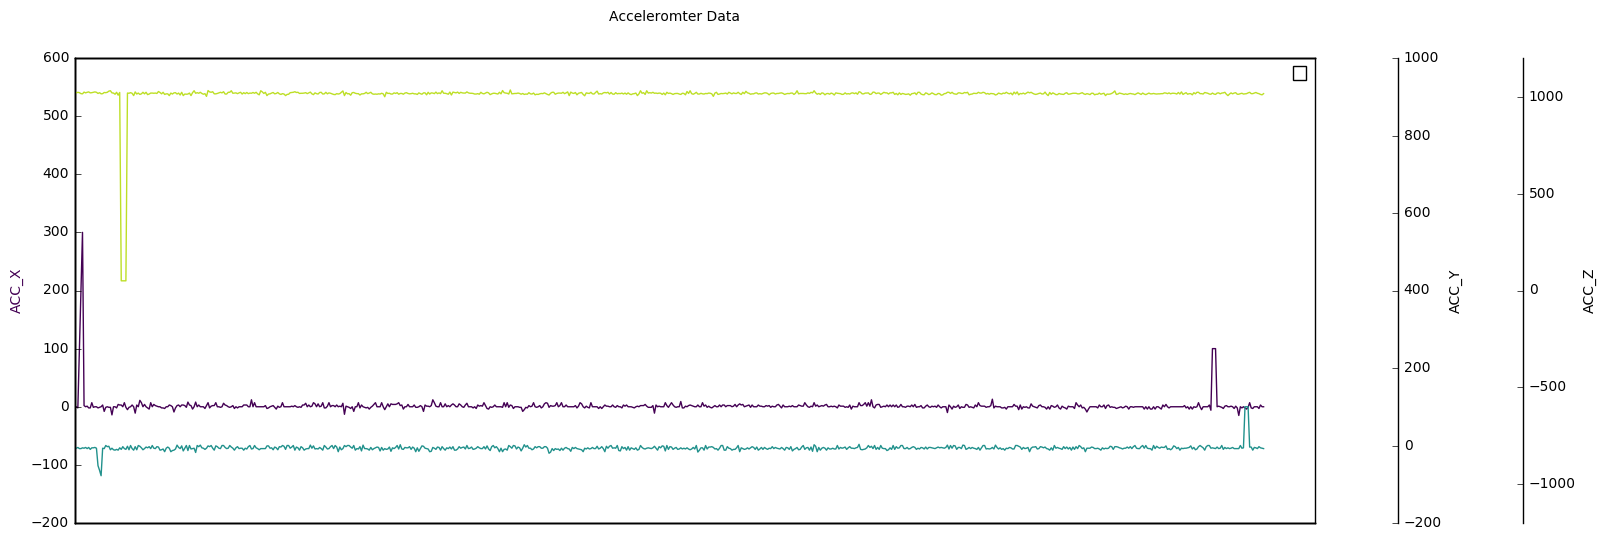

In [23]:
ACC_X = df_Accelerometer["ACC_X"].values
ACC_Y = df_Accelerometer["ACC_Y"].values
ACC_Z = df_Accelerometer["ACC_Z"].values
t =[x for x in range(len(ACC_X))]

fig = plt.figure(figsize=(16,6))
host = fig.add_subplot(111)
plt.suptitle("Acceleromter Data")

par1 = host.twinx()
par2 = host.twinx()

host.set_ylim(-200, 600)
par1.set_ylim(-200, 1000)
par2.set_ylim(-1200, 1200)

host.set_xlabel("")
host.xaxis.set_label_position('top') 
        
host.set_ylabel("ACC_X")
par1.set_ylabel("ACC_Y")
par2.set_ylabel("ACC_Z")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

p1, = host.plot(t, ACC_X, color=color1,label="ACC_X")
p2, = par1.plot(t, ACC_Y, color=color2, label="ACC_Y")
p3, = par2.plot(t, ACC_Z, color=color3, label="ACC_Z")

lns = []

# right, left, top, bottom
par1.spines['right'].set_position(('outward', 60))                  
par1.xaxis.set_ticks([])

par2.spines['right'].set_position(('outward', 150))                  
par2.xaxis.set_ticks([])

host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())

plt.show()

## 4. Data Preparation <a class="anchor" id="Data-Preparation"></a>

In [24]:
# Generate train data
X_train = df_Accelerometer[['ACC_X', 'ACC_Y', 'ACC_Z']].values

## 5. Algorithm Evaluation <a class="anchor" id="Algorithm-Evaluation"></a>

### 5.1. Test Options and Evaluation Metrics <a class="anchor" id="Test-Options-Evaluation-Metrics"></a>

In [25]:
rng = np.random.RandomState(11)
n_samples = len(t)
outliers_fraction = 0.02
clusters_separation = [0]

### 5.2. Evaluate Anomaly Detection Algorithms <a class="anchor" id="Evaluate-AnomalyDetection-Algorithms"></a>

In [26]:
y_predvals = []

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.0084, kernel="rbf", gamma=0.0001),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,contamination=outliers_fraction,random_state=rng)}

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):

    # Fit the model
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X_train)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X_train)
            scores_pred = clf.decision_function(X_train)
            y_pred = clf.predict(X_train)
        
        y_predvals.append(y_pred)

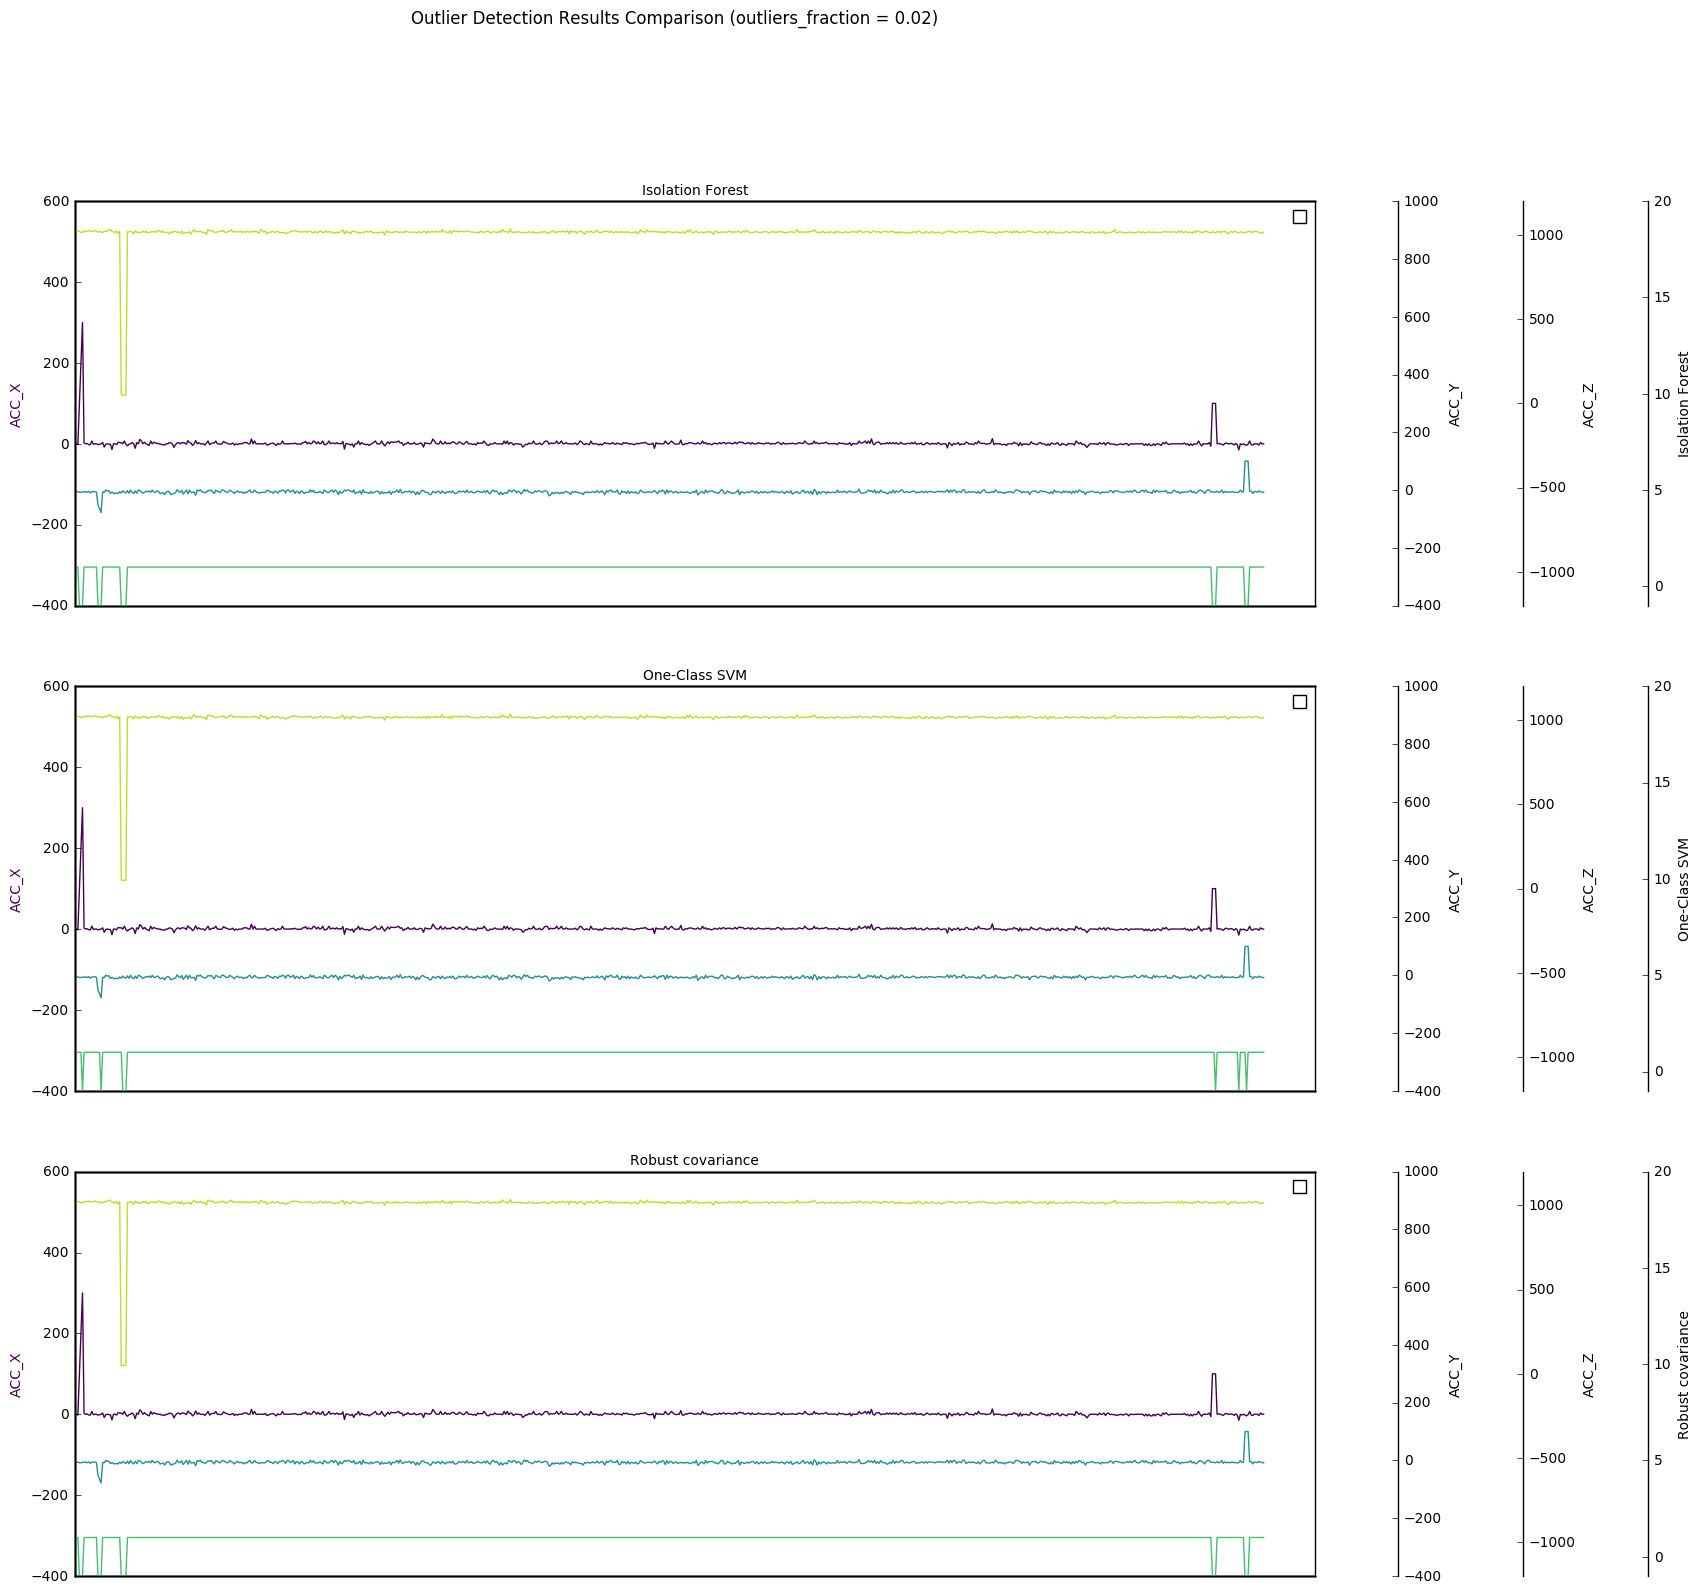

In [29]:
fig = plt.figure(figsize=(16,24))
plt.suptitle("Outlier Detection Results Comparison (outliers_fraction = %s)" % str(outliers_fraction), fontsize=12)

for i, value in enumerate(y_predvals):
    host = fig.add_subplot(411 + i)

    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()
    
    host.set_ylim(-400, 600)
    par1.set_ylim(-400, 1000)
    par2.set_ylim(-1200, 1200)
    par3.set_ylim(-1, 20)
    
    host.set_xlabel(list(classifiers.keys())[i])
    host.xaxis.set_label_position('top') 
        
    host.set_ylabel("ACC_X")
    par1.set_ylabel("ACC_Y")
    par2.set_ylabel("ACC_Z")                    
    par3.set_ylabel(list(classifiers.keys())[i])

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)
    color4 = plt.cm.viridis(.7)
    

    p1, = host.plot(t, ACC_X, color=color1,label="ACC_X")
    p2, = par1.plot(t, ACC_Y, color=color2, label="ACC_Y")
    p3, = par2.plot(t, ACC_Z, color=color3, label="ACC_Z")
    p4, = par3.plot(t, y_predvals[i], color=color4, label=list(classifiers.keys())[i])

    lns = []

    # right, left, top, bottom
    par1.spines['right'].set_position(('outward', 60))                  
    par1.xaxis.set_ticks([])

    par2.spines['right'].set_position(('outward', 150))                  
    par2.xaxis.set_ticks([])

    par3.spines['right'].set_position(('outward', 240))                  
    par3.xaxis.set_ticks([])

    host.legend(handles=lns, loc='best')

    host.yaxis.label.set_color(p1.get_color())
plt.show()